In [1]:
import cv2 #type: ignore
import numpy as np  #type: ignore
import matplotlib.pyplot as plt  #type: ignore
import matplotlib.image as mpimg  #type: ignore


import tensorflow as tf  #type: ignore
from keras.models import Model # type: ignore
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout # type: ignore
from keras.optimizers import Adam # type: ignore

In [2]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "  # The set of valid characters
max_str_len = 50                             # Maximum length of input labels
num_of_characters = len(alphabets) + 1       # Number of unique characters, plus 1 for CTC pseudo-blank
num_of_timestamps = 64   

In [3]:
path_to_model_weight = 'trained_model_13_3.h5' # the best model weight
#path_to_model_weight = 'trained_model_12_3.h5' # previous version


# Define the input layer with a shape of (256, 64, 1) for grayscale images
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional Layer 1: 32 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)  # Batch normalization
inner = Activation('relu')(inner)  # ReLU activation
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # Max-pooling

# Convolutional Layer 2: 64 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

# Convolutional Layer 3: 128 filters, (3, 3) kernel, 'same' padding, He normal initialization
inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# Reshape the output for sequence processing
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)

# Fully Connected Layer 1: 64 units, ReLU activation, He normal initialization
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# Bidirectional LSTM Layers: 256 units, return sequences
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output Layer: Number of characters, He normal initialization
inner = Dense(num_of_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)  # Softmax activation
# Create the model with input and output layers
model = Model(inputs=input_data, outputs=y_pred)

model.load_weights(path_to_model_weight)

# The ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # The 2 is critical here since the first couple outputs of the RNN tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# Define input placeholders for true labels, input sequence length, and label sequence length
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# Calculate CTC loss using the ctc_lambda_func function
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Create the final model that takes input data, true labels, input length, and label length
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
# Compile the final model with a dummy loss lambda function (loss calculation occurs elsewhere)
# The optimizer used is Adam with a learning rate of 0.0001
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))

In [4]:
# Fuction to preprocess the img
def preprocess(img):
    (h, w) = img.shape                                    # Getting the height & width of the image
    
    final_img = np.ones([64, 256])*255                    # Blank white image
    
    # crop    
    if h > 64:
        img = img[:64, :]                                 # If the h>64 then it is cropped to 64
        
    if w > 256:
        img = img[:, :256]                                # If the w>256 then it is cropped to 256
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE) # Rotate 90° Clockwise & return

In [5]:
def label_to_num(label):
    return np.array([alphabets.find(ch) for ch in label])


def num_to_label(num):
    return ''.join([alphabets[ch] for ch in num if ch != -1])

blank_label = -1

In [6]:
def resize_with_aspect_ratio(image, target_size=(64, 256)):
    (h, w) = image.shape
    target_h, target_w = target_size
    
    scale = min(target_h / h, target_w / w)  # Calculate scale to fit target size
    new_h = int(h * scale)
    new_w = int(w * scale)
    
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)  # Resize while preserving aspect ratio
    final_img = np.ones((target_h, target_w)) * 255  # Blank white image of target size
    final_img[:new_h, :new_w] = resized_img  # Place resized image in top-left corner
    
    return final_img

In [7]:
def predict(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    image = preprocess(image)
    image = image / 255.0
    
    # Reshape the image to have a batch size of 1
    image = image.reshape(1, 256, 64, 1)
    
    pred = model.predict(image)
    decoded = tf.keras.backend.get_value(
        tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0]
    )
    
    return num_to_label(decoded[0])

In [8]:
def sliding_window_prediction(image, window_size=(64, 256), step_size=128):
    (h, w) = image.shape
    
    if h < window_size[0]:  # Pad height if it's smaller than 64
        padding_h = window_size[0] - h
        image = np.pad(image, ((0, padding_h), (0, 0)), 'constant', constant_values=255)
    
    if w < window_size[1]:  # Pad width if it's smaller than 256
        padding_w = window_size[1] - w
        image = np.pad(image, ((0, 0), (0, padding_w)), 'constant', constant_values=255)
    
    results = []
    
    for x in range(0, w - window_size[1] + 1, step_size):  # Slide window horizontally
        window = image[:, x:x + window_size[1]]  # Extract the window
        pred_text = predict(window)  # Predict text in the window
        results.append(pred_text)  
    
    return ''.join(results)  # Combine predictions from all windows

In [9]:
def pad_image_to_fixed_size(image, target_size=(64, 256)):
    (h, w) = image.shape
    target_h, target_w = target_size
    
    if h > target_h:  # Crop height if larger than target
        image = image[:target_h, :]
    
    final_img = np.ones(target_size) * 255  # Blank white image
    final_img[:h, :w] = image  # Place original image in top-left corner
    
    return final_img

In [10]:
def process_large_image(image, part_width=256):
    (h, w) = image.shape
    results = []
    
    for start_x in range(0, w, part_width):  # Divide image into sub-images
        part_img = image[:, start_x:start_x + part_width]  # Extract part of the image
        padded_img = pad_image_to_fixed_size(part_img)  # Pad to fixed size (64, 256)
        pred_text = predict(padded_img)  # Predict text for the sub-image
        results.append(pred_text)  
    
    return ''.join(results)  # Combine predictions from all sub-images

In [11]:
def postprocess(image,text):
    if(text[-4:]== 'EPTY'):
        text = text[:-4]

    image = mpimg.imread(image)
    plt.imshow(image)
    plt.axis('off')  # Menyembunyikan axis
    plt.show()

    print("predicted:",text)
    print("len:",len(text))
    print('')

index 0
prepared image to analyse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


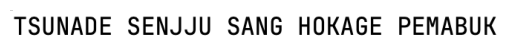

predicted: TOUNADE SENUSANG HOKAGEPEMABUK
len: 30

index 1
prepared image to analyse
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


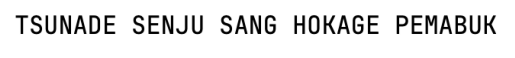

predicted: TOUNADE SENJUSANG HOKAGEPEMABUK
len: 31



In [14]:
#1-4
for i in range(0,2):
    print(f'index {i}')
    print('prepared image to analyse')
    name = f'./test_v2/test/Capital/33-36/TEST_{i}.png'
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)  # Read grayscale image
    result_text = process_large_image(image)
    postprocess(name,result_text)

    